# ADS Independent citation counter

In this notebook, I query ADS for independent citations to all of my peer-reviewed publications. I do this by looping over all refereed papers and excluding all authors of that paper from the query. We match on the last name and initials (as does ADS) and use ORCID iD for cross-checking whenever available.

In [1]:
! date

Mon Aug 23 09:45:46 EDT 2021


In [2]:
import requests, json
from collections import Counter
from getpass import getpass

#### Enter your API key below. 

To obtain an API key, you need to be logged in to your ADS account. Sign up for one with your email if you have never logged in. Go to **Account** > **Settings** > **API token** and copy your unique 40-character API key and enter when prompted. Note that your key is not stored encrypted, therefore printing the variables `token` or `headers` variable will reveal your key.

In [3]:
## Configuration
token = getpass("Enter your 40-character ADS API key: ")
headers={'Authorization': 'Bearer ' + token}

check_orcid = True
verbose = False  # Set it to True if you want lengthy outputs

Enter your 40-character ADS API key:  ········································


In [4]:
## Define a convenience function to standardize the names
def standardize_names(name):
    if not "," in name:
        return name
    try:
        lastname, firstname = name.split(',')
        initial = firstname[1]
        return f"{lastname},+{initial}"
    except:
        # This usually happens for collaboration papers
        print(f"Cannot split '{name}' into first and last names!")
        return name

First, query for all refereed papers authored by Kannawadi, Arun

In [5]:
%%time
author=standardize_names('Kannawadi, Arun')

base_url = "https://api.adsabs.harvard.edu/v1/search/query?"
fq = "property%3Arefereed+property%3Aarticle"
fq = "property%3Aarticle"
fl = "author,title,bibcode,citation_count,orcid_pub,orcid_user,orcid_other,property"
rows = 500

# the query parameters can be included as part of the URL
url = f"{base_url}q=author%3A{author}&fq={fq}&fl={fl}&rows={rows}"
print(f"URL = {url}\n")
r = requests.get(url, headers=headers)
# the requests package returns an object; to get just the JSON API response, you have to specify this
js = r.json()
publications = js['response']['docs']

URL = https://api.adsabs.harvard.edu/v1/search/query?q=author%3AKannawadi,+A&fq=property%3Aarticle&fl=author,title,bibcode,citation_count,orcid_pub,orcid_user,orcid_other,property&rows=500

CPU times: user 26.7 ms, sys: 8.36 ms, total: 35.1 ms
Wall time: 684 ms


In [6]:
## Print the complete list of queried papers
print("Complete list of queried papers")
print("\t   Bibcode       #Cites \t Title\n")
citation_counts = 0
for paper in publications:
    print(paper['bibcode'], '\t', paper['citation_count'], '\t', paper['title'][0])
    citation_counts += paper['citation_count']
print("\nTotal number of citations = ", citation_counts)

Complete list of queried papers
	   Bibcode       #Cites 	 Title

2020A&A...633A..69H 	 195 	 KiDS+VIKING-450: Cosmic shear tomography with optical and infrared data
2021A&A...646A.140H 	 125 	 KiDS-1000 Cosmology: Multi-probe weak gravitational lensing and spectroscopic galaxy clustering constraints
2014ApJS..212....5M 	 120 	 The Third Gravitational Lensing Accuracy Testing (GREAT3) Challenge Handbook
2021A&A...645A.104A 	 113 	 KiDS-1000 cosmology: Cosmic shear constraints and comparison between two point statistics
2020A&A...638L...1J 	 93 	 KiDS+VIKING-450 and DES-Y1 combined: Cosmology with cosmic shear
2020A&A...634A.127A 	 61 	 KiDS+VIKING-450 and DES-Y1 combined: Mitigating baryon feedback uncertainty with COSEBIs
2020A&A...633L..10T 	 58 	 Cosmology from large-scale structure. Constraining ΛCDM with BOSS
2019A&A...624A..92K 	 42 	 Towards emulating cosmic shear data: revisiting the calibration of the shear measurements for the Kilo-Degree Survey
2021A&A...646A.129J 	 34 	 KiD

In [7]:
## Ensure that the Orcid iDs are consistent and create a single orcid key per author
for paper in publications:
    nauth = len(paper['author'])
    paper['orcid'] = []
    for aid in range(nauth):
        orcid = (paper['orcid_pub'][aid], paper.get('orcid_user','-'*nauth)[aid], paper.get('orcid_other','-'*nauth)[aid])
        orcid = [orc for orc in orcid if orc!='-']
        if len(orcid):
            all((orc==orcid[0] for orc in orcid))
            paper['orcid'].append(orcid[0])
        else:
            paper['orcid'].append('-')
        if verbose:
            print(paper['author'][aid], paper['orcid_pub'][aid], paper.get('orcid_user','-'*nauth)[aid], paper.get('orcid_other','-'*nauth)[aid])
            print(paper['author'][aid], paper.get('orcid')[aid])


This would have been an excellent exercise to use a mini database, with a Publications table and an Authors table. But for my purpose, this seemed like an overkill and I use basic Python structures like `dict` and `list`.

In [8]:
## Obtain the complete list of co-authors (including self), along with their unique ORCID iDs.
coauthors = {}
for paper in publications:
    for auth, orc in zip(paper['author'], paper['orcid']):
        std_name = standardize_names(auth)
        coauthors[std_name] = orc if orc!='-' else coauthors.get(std_name, None)
if verbose:
    print("\nName of the co-authors \t\t ORCID iD \n ")
    for coauth in sorted(coauthors.keys()):
        print(coauth, '\t\t', coauthors[coauth])

Unfortunately, many of my co-authors have not provided their ORCID iD. We will have to find common authors by name. ORCID iD will only serve as further validation where applicable.

In [9]:
print("The following authors have the same last name:")
cntr = Counter([name.split(',')[0] for name in coauthors.keys()])
for coauth in coauthors:
    if cntr[coauth.split(',')[0]] > 1:
        print(coauth, '\t', coauthors[coauth])

The following authors have the same last name:
Choi,+A 	 None
Armstrong,+B 	 None
Taylor,+A 	 None
Taylor,+E 	 0000-0002-5522-9107
Choi,+S 	 None
Li,+X 	 None
Armstrong,+R 	 None
Li,+S 	 0000-0001-9952-7408


Define an empty dictionary to contain the number of independent citations. Loop over the above publications, query the independent citations and count them.

In [10]:
%%time
fq = "property%3Aarticle"
fl = "author,title,bibcode"
rows = 500
for eid, entity in enumerate(js['response']['docs']):
    independent_authors, independent_orcid = [], []
    bibcode = entity['bibcode'].replace('&','%26')
    condition = ''
    for auth in entity['author']:
        name = standardize_names(auth)
        if name is None: continue
        condition+= f"+-author:%22{name}%22"
    url = f"{base_url}q=citations(bibcode%3A{bibcode}){condition}&fq={fq}&fl={fl}&rows={rows}"
    r = requests.get(url, headers=headers)
    jstmp = r.json()
    independent_authors += [standardize_names(paper['author']) for paper in jstmp['response']['docs']]
    nauth = len(entity['author'])
    if check_orcid:
        # Get all coauthor orcid ids
        coauthor_orcid = entity.get('orcid_pub',['-'])+entity.get('orcid_user',['-'])+entity.get('orcid_other',['-'])
        for cite in jstmp['response']['docs']:
            independent_orcid += cite.get('orcid_user',['-'])+cite.get('orcid_pub',['-'])+cite.get('orcid_other',['-'])

        independent_orcid = set(independent_orcid)
        coauthor_orcid = set(coauthor_orcid)
        assert(independent_orcid.intersection(coauthor_orcid).issubset({'-'}))

    js['response']['docs'][eid]['independent_citation_count'] = jstmp['response']['numFound']

CPU times: user 745 ms, sys: 60 ms, total: 805 ms
Wall time: 11.8 s


In [11]:
## Print the complete list of queried papers, with independent citations counts for each
def print_independent_citation_counts(refereed_only=True, verbose=False, topn=1000):
    print("Complete list of queried papers")
    print("\t   Bibcode       #Cites #Independent cites \t Title\n")
    citation_counts, independent_citation_counts = 0, 0
    kids_citation_counts = 0
    for paper in publications[:topn]:
        if refereed_only and 'NOT REFEREED' in paper['property']:
            continue
        if verbose:
            print(paper['bibcode'], '\t', paper['citation_count'], paper['independent_citation_count'], '\t', paper['title'][0])
        citation_counts += paper['citation_count']
        independent_citation_counts += paper['independent_citation_count']
        if 'kids' in paper['title'][0].lower():
            kids_citation_counts += paper['independent_citation_count']
    print("\nTotal number of citations = ", citation_counts)
    print("\nTotal number of independent citations = ", independent_citation_counts)
    print("\nTotal number of independent citations from KiDS papers = ", kids_citation_counts)
    return independent_citation_counts

In [12]:
independent_citation_counts = print_independent_citation_counts(refereed_only=False, verbose=True, topn=10)

Complete list of queried papers
	   Bibcode       #Cites #Independent cites 	 Title

2020A&A...633A..69H 	 195 123 	 KiDS+VIKING-450: Cosmic shear tomography with optical and infrared data
2021A&A...646A.140H 	 125 78 	 KiDS-1000 Cosmology: Multi-probe weak gravitational lensing and spectroscopic galaxy clustering constraints
2014ApJS..212....5M 	 120 64 	 The Third Gravitational Lensing Accuracy Testing (GREAT3) Challenge Handbook
2021A&A...645A.104A 	 113 86 	 KiDS-1000 cosmology: Cosmic shear constraints and comparison between two point statistics
2020A&A...638L...1J 	 93 72 	 KiDS+VIKING-450 and DES-Y1 combined: Cosmology with cosmic shear
2020A&A...634A.127A 	 61 36 	 KiDS+VIKING-450 and DES-Y1 combined: Mitigating baryon feedback uncertainty with COSEBIs
2020A&A...633L..10T 	 58 39 	 Cosmology from large-scale structure. Constraining ΛCDM with BOSS
2019A&A...624A..92K 	 42 15 	 Towards emulating cosmic shear data: revisiting the calibration of the shear measurements for the Kilo-

Voila! We have calculated independent citation counts for each referee publication of mine, and the total number of independent citations.

#### Now, calculate the citations from one specific author

In [13]:
def citations_counts_from(other_author, verbose=False):
    """
    Count the number of citations from a particular author.
    """
    other_author = standardize_names(other_author)
    other_citation_count = 0
    # https://ui.adsabs.harvard.edu/search/filter_author_facet_hier_fq_author=AND&filter_author_facet_hier_fq_author=author_facet_hier%3A%220%2FTroxel%2C%20M%22&fq=%7B!type%3Daqp%20v%3D%24fq_author%7D&fq_author=(author_facet_hier%3A%220%2FTroxel%2C%20M%22)&q=citations(bibcode%3A2015MNRAS.449.3597K)&sort=date%20desc%2C%20bibcode%20desc&p_=0
    fq = "property%3Aarticle"
    fl = "author,title,bibcode"
    rows = 500
    for eid, entity in enumerate(js['response']['docs']):
        independent_authors, independent_orcid = [], []
        bibcode = entity['bibcode'].replace('&','%26')
        condition = ''
        url = (f"{base_url}filter_author_facet_hier_fq_author=AND&"
                "filter_author_facet_hier_fq_author=author_facet_hier%3A%220%2F"
                f"{other_author}&fq=%7B!type%3Daqp%20v%3D%24fq_author%7D&"
                f"fq_author=(author_facet_hier%3A%220%2F{other_author})&"
                f"q=citations({bibcode})&sort=date%20desc%2C%20bibcode%20desc&p_=0&rows=500")
        r = requests.get(url, headers=headers)
        jstmp = r.json()
        if verbose:
            print(bibcode, len(jstmp['response']['docs']))
        other_citation_count += len(jstmp['response']['docs'])

    return other_citation_count


In [14]:
other_author = "Troxel, M"
other_citation_count = citations_counts_from(other_author)
print(f"Number of citations from {other_author} = {other_citation_count}")

Number of citations from Troxel, M = 105


## Consistency check

If you are the other author, then the citations from you to your papers should match exactly the number of self-citations that is reported in the metrics

In [15]:
other_citation_count = citations_counts_from("Kannawadi, A")
# to pass a dictionary in the request payload, convert it to a string first using the json package
payload = {"bibcodes": [paper['bibcode'] for paper in publications], \
           "types":["citation_stats"], "histograms":["citations"]}
metrics = requests.post("https://api.adsabs.harvard.edu/v1/metrics", \
                 headers={"Authorization": "Bearer " + token, "Content-type": "application/json"}, \
                 data=json.dumps(payload))
metrics = metrics.json()
print("Number of self-citations counted from ADS metrics = ", metrics["citation stats"]["number of self-citations"])
print("Number of self-ctiations counted from our loop = ", other_citation_count)
assert metrics["citation stats"]["number of self-citations"] == other_citation_count


Number of self-citations counted from ADS metrics =  185
Number of self-ctiations counted from our loop =  185


In [ ]:
## Comapre citations to my papers with others



In [16]:
base_url = "https://api.adsabs.harvard.edu/v1/search/query?"
fq = "property%3Arefereed+property%3Aarticle"
#fq = "property%3Aarticle"
fl = "date,pubdate,citation_count"

rows = 10 # we are not interested in the actual documents, just the metadata

year = "2019-2020"
min_count, max_count = 0, 9000
keyword = "cosmolog*"

query = f'year%3A{year}%20citation_count%3A0%20AND%20keyword%3A"{keyword}"'
# the query parameters can be included as part of the URL
url = f'{base_url}q={query}&fq={fq}&fl={fl}&rows={rows}'
# q=year%3A2019-2020%20AND%20citation_count%3A%5B0%20TO%20192%5D%20AND%20keyword%3A"cosmolog*"
r = requests.get(url, headers=headers)
# the requests package returns an object; to get just the JSON API response, you have to specify this
js = r.json()
count_bins = [js['response']['numFound']]

for count in range(0,500,10):
    query = f'year%3A{year}%20citation_count%3A%5B{count+1}%20TO%20{count+10}%5D%20AND%20keyword%3A"{keyword}"'
    # the query parameters can be included as part of the URL
    url = f'{base_url}q={query}&fq={fq}&fl={fl}&rows={rows}'
    # q=year%3A2019-2020%20AND%20citation_count%3A%5B0%20TO%20192%5D%20AND%20keyword%3A"cosmolog*"
    r = requests.get(url, headers=headers)
    # the requests package returns an object; to get just the JSON API response, you have to specify this
    js = r.json()
    count_bins += [ js['response']['numFound'] ]

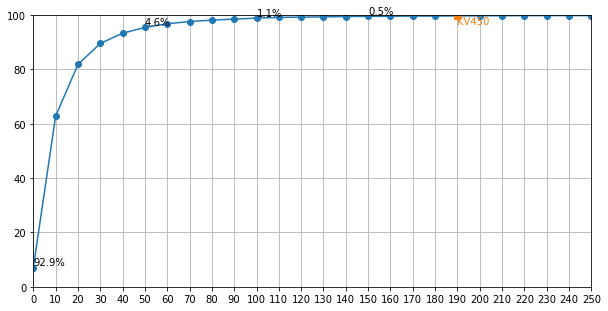

In [17]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
X = range(0, 510, 10)
Y = 100*np.cumsum(count_bins)/np.sum(count_bins) 
plt.figure(figsize=(10,5))
plt.plot(X, Y,'o-')
for i,(x,y) in enumerate(zip(X,Y)):
	if not i in [0, 5, 10, 15]: continue
	plt.text(x,y,str(round(100-y,1))+'%', ha='left', va='bottom')
plt.plot(X[19], Y[19],'s', color='C1')
plt.annotate(text="KV450", xy=(X[19], Y[19]), va='top', ha='left', color='C1')
plt.xticks(X)
plt.xlim([0,250])
plt.ylim([0.0,100.0])
plt.grid(True, which='major')